In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import sklearn.decomposition
import sklearn.linear_model
import sklearn.feature_extraction
import matplotlib.pyplot as plt
import datetime
import dateutil
import multiprocessing
import sharedmem
import random
import gc
import tempfile

In [2]:
courses = pd.read_csv('course.csv')
courses

,date,change_rate,delta_addictive,delta_mul
0,11.01.2007,26.4898,0.0433,1.001637
1,12.01.2007,26.5320,0.0422,1.001593
2,13.01.2007,26.5770,0.0450,1.001696
3,16.01.2007,26.5645,-0.0125,0.999530
4,17.01.2007,26.5481,-0.0164,0.999383
5,18.01.2007,26.5646,0.0165,1.000622
6,19.01.2007,26.5343,-0.0303,0.998859
7,20.01.2007,26.5075,-0.0268,0.998990
8,23.01.2007,26.5214,0.0139,1.000524
9,24.01.2007,26.5240,0.0026,1.000098


In [3]:
courses_list = courses.to_dict('records')
for record in courses_list:
    record['date'] = dateutil.parser.parse(record['date'], dayfirst=True).date()

In [4]:
def get_ema(sequence,):
    alpha = 2 / (len(sequence) + 1)
    ema = 0
    for value in sequence:
        ema = (1 - alpha) * ema + alpha * value
    return ema

def get_ema_for_day(data, query_index, period, value_getter):
    first_date = data[query_index]['date'] + datetime.timedelta(days=-period)
    first_date_index = query_index
    while first_date_index > 0 and data[first_date_index - 1]['date'] >= first_date:
        first_date_index -= 1
    assert query_index + 1 - first_date_index <= period
    return get_ema([value_getter(d) for d in data[first_date_index:query_index + 1]])

In [5]:
def get_signal(yestarday, today):
    if (yestarday['macd'] - yestarday['macd_signal']) * (today['macd'] - today['macd_signal']) >= 0:
        return None
    if yestarday['macd'] - yestarday['macd_signal'] < 0:
        return 'Buy'
    return 'Sell'

for day_index, day_data in enumerate(courses_list):
    day_data['ema_12'] = get_ema_for_day(courses_list, day_index, 12, lambda d: d['change_rate'])
    day_data['ema_26'] = get_ema_for_day(courses_list, day_index, 26, lambda d: d['change_rate'])
    day_data['macd'] = day_data['ema_12'] - day_data['ema_26']
    day_data['macd_signal'] = get_ema_for_day(courses_list, day_index, 9, lambda d: d['macd'])
    if day_index > 0:
        day_data['vote'] = get_signal(courses_list[day_index - 1], day_data)
    else:
        day_data['vote'] = None

In [10]:
courses_macd = pd.DataFrame(courses_list)

votes = courses_macd[['date', 'vote']]
votes.to_csv('macd.csv', index=False)

macd_strategy = {k:v['vote'] for k,v in votes.set_index('date').to_dict('index').items()}

## Get ML strategy

In [13]:
svd = sklearn.decomposition.TruncatedSVD(1700)
X_svd = svd.fit_transform(sklearn.preprocessing.scale(np.load('lemmas/2010p/bow_avg_2010.npy'), copy=False))
gc.collect()

28

In [14]:
abs_deltas = courses.set_index('date').to_dict()['delta_addictive']
with open('lemmas/2010p/avg_ccl.txt') as fl:
    dates = [dateutil.parser.parse(line[:line.find(' ')]).date() for line in fl]
y_all = np.array([1 if abs_deltas[x.strftime('%d.%m.%Y')] > 0 else -1 for x in dates])

In [15]:
X_svd, y_all = sharedmem.copy(X_svd), sharedmem.copy(y_all)
gc.collect()

229

In [16]:
def get_ml_predict(cls, X, y, train_valid_split, print_progress=False):
    ml_predictions = dict()
    start_day_index = int(len(X) * train_valid_split)
    for prediction_day_index in range(start_day_index, len(X)):
        cls.fit(X[:prediction_day_index], y[:prediction_day_index])
        ml_predictions[dates[prediction_day_index]] = cls.predict(X[prediction_day_index].reshape(1, -1))[0]
        if print_progress:
            print("\rDone {:.2%} percents".format((prediction_day_index - start_day_index + 1) / (len(X) - start_day_index)), end='')
    return ml_predictions

In [79]:
ml_predictions = get_ml_predict(
    sklearn.linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-4, l1_ratio=0.2, tol=1e-4, random_state=42),
    X_svd, y_all, 0.5
)

In [30]:
preds = np.squeeze(np.array([ml_predictions[k] for k in sorted(ml_predictions.keys())]))

In [31]:
(y_all[start_day_index:] == preds).sum() / len(preds)

0.5266331658291458

In [15]:
true_predict = {date:(1 if abs_deltas[date.strftime('%d.%m.%Y')] > 0 else -1) for date in dates}

In [16]:
sum(1 for date in ml_predictions if ml_predictions[date] == true_predict[date]) / len(ml_predictions)

0.5266331658291458

## Compare strategies

In [17]:
course_values = {datetime.datetime.strptime(k, '%d.%m.%Y').date():v for k, v in courses.set_index('date')['change_rate'].to_dict().items()}

class BaseStrategy:
    def __init__(self, start_pool):
        self.rub_money = start_pool
        self.dol_money = 0
    
    def rub2dol(self, money, course):
        assert money <= self.rub_money
        self.rub_money -= money
        self.dol_money += money / course
    
    def dol2rub(self, money, course):
        assert money <= self.dol_money
        self.dol_money -= money
        self.rub_money += money * course
    
    def total_rubles(self, date):
        return self.rub_money + self.dol_money * course_values[date]
    
    def total_dollars(self, date):
        return self.dol_money + self.rub_money / course_values[date]

class MACDStratery(BaseStrategy):
    def __init__(self, start_pool, macd_votes):
        super().__init__(start_pool)
        self.macd_votes = macd_votes
    
    def on_date(self, date):
        if self.macd_votes[date] == 'Buy':
            self.rub2dol(self.rub_money, course_values[date])
        elif self.macd_votes[date] == 'Sell':
            self.dol2rub(self.dol_money, course_values[date])

class NaiveMLStrategy(BaseStrategy):
    def __init__(self, start_pool, predicted_changes):
        super().__init__(start_pool)
        self.predicted_changes = predicted_changes
    
    def on_date(self, date):
        if self.predicted_changes[date] > 0:
            self.rub2dol(self.rub_money, course_values[date])
        else:
            self.dol2rub(self.dol_money, course_values[date])

def run_strategy(strategy, date_list):
    total_rubles, total_dollars = [], []
    for date in date_list:
        strategy.on_date(date)
        total_rubles.append(strategy.total_rubles(date))
        total_dollars.append(strategy.total_dollars(date))
    return np.array(total_rubles), np.array(total_dollars)


In [37]:
start_pool = 100000
run_dates = dates[len(dates) // 2:]
run_results = {
    'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates),
    'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)
}

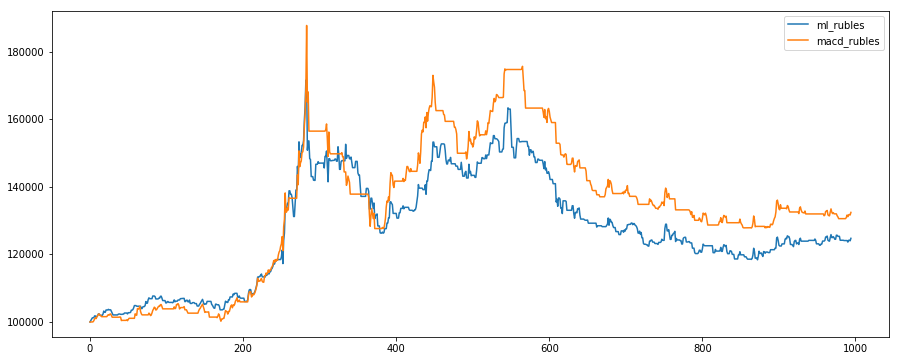

In [38]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][0])
plt.plot(run_results['macd'][0])
plt.legend(['ml_rubles', 'macd_rubles'])

plt.show()

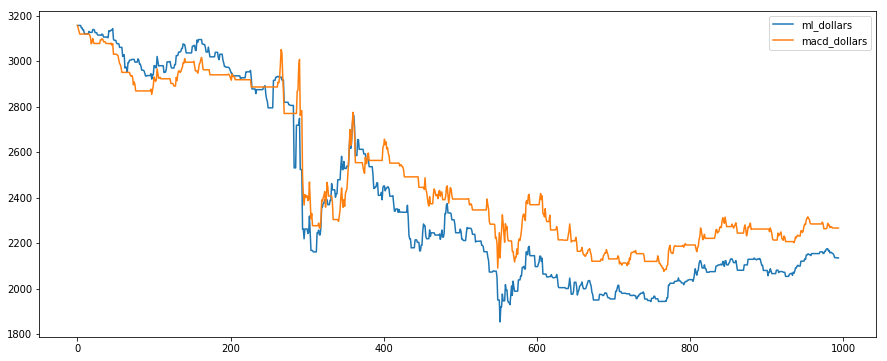

In [39]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][1])
plt.plot(run_results['macd'][1])
plt.legend(['ml_dollars', 'macd_dollars'])

plt.show()

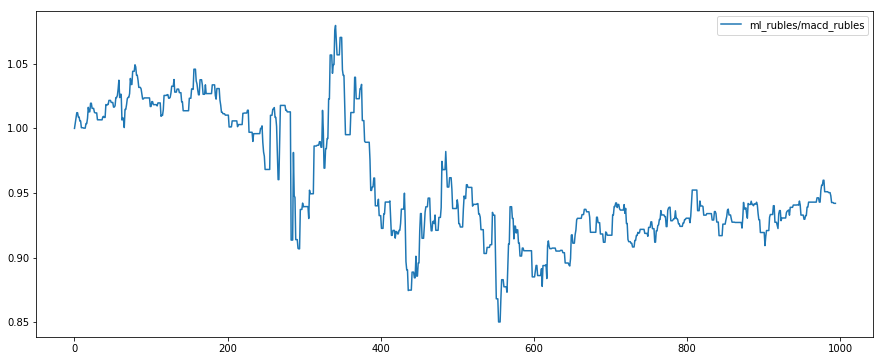

In [41]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][0]/run_results['macd'][0])
plt.legend(['ml_rubles/macd_rubles'])

plt.show()

## Choose ML parameters

In [18]:
def get_cls_score_vs_macd(cls, X, y, test_valid_split):
    ml_predictions = get_ml_predict(cls, X, y, test_valid_split)
    start_pool = 100000
    run_dates = dates[int(len(X) * test_valid_split):len(X)]
    run_results = {
        'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates),
        'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)
    }
    return run_results['ml'][0] / run_results['macd'][0]

exp_range = [10**p for p in range(-5, 6)]
range_01 = [n / 10 for n in range(0, 11)]
sgd_params = {
    'loss': ['hinge', 'log'],
    'penalty': ['elasticnet'],
    'alpha': exp_range,
    'l1_ratio': range_01,
    'tol': [1e-4],
    'random_state': [42],
}

def get_all_params(params):
    import itertools
    return [{k:v for k, v in zip(params.keys(), values)} for values in itertools.product(*(params.values()))]

def _get_result_dict(map_params):
    cls, cls_params, X, y, test_valid_split = map_params
    result_dict = cls_params.copy()
    result_dict['score_array'] = get_cls_score_vs_macd(cls, X, y, test_valid_split)
    return result_dict

def run_grid_search(cls_type, all_params, X, y, test_valid_split, print_progress=False):
    result_list = []
    with multiprocessing.Pool(8) as pool:
        inputs = [(cls_type(**params), params, X, y, test_valid_split) for params in all_params]
        random.shuffle(inputs)
        results = pool.imap_unordered(_get_result_dict, inputs)
        pool.close()
        for i, result in enumerate(results):
            result_list.append(result)
            if print_progress:
                print("\rDone {:.2%} percents".format((i + 1) / len(all_params)), end='')
    return result_list

In [19]:
train_test_split = int(0.75 * len(X_svd))
train_valid_split = 1/2 / 0.75

In [20]:
cv_results = run_grid_search(sklearn.linear_model.SGDClassifier, get_all_params(sgd_params),
                             X_svd[:train_test_split], y_all[:train_test_split],
                             train_valid_split, print_progress=True)

Done 6.20% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 7.02% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 12.81% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 17.36% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 22.73% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 36.36% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 44.63% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 100.00% percents

In [21]:
# by last value
cv_by_last_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'][-1]} for r in cv_results]).sort_values('score', ascending=False)
cv_by_last_value

,alpha,l1_ratio,loss,score
223,0.10000,0.6,hinge,1.353139
208,0.00001,0.9,log,1.327877
113,0.10000,0.7,hinge,1.318944
78,0.00001,0.5,hinge,1.305397
235,0.00001,0.7,log,1.304230
4,0.00001,0.7,hinge,1.283259
29,0.10000,0.4,hinge,1.277519
163,0.01000,0.1,hinge,1.273034
107,0.00010,0.7,hinge,1.254284
51,0.00001,0.8,log,1.253349


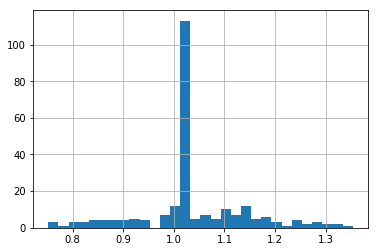

In [25]:
cv_by_last_value['score'].hist(bins=30)

In [26]:
cv_by_avg_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'].mean()} for r in cv_results]).sort_values('score', ascending=False)
cv_by_avg_value

,alpha,l1_ratio,loss,score
223,0.10000,0.6,hinge,1.146686
113,0.10000,0.7,hinge,1.135369
132,0.10000,0.7,log,1.132662
163,0.01000,0.1,hinge,1.128653
78,0.00001,0.5,hinge,1.102883
4,0.00001,0.7,hinge,1.102678
29,0.10000,0.4,hinge,1.089879
85,0.00010,0.1,log,1.089255
47,10.00000,0.0,log,1.087337
87,1.00000,0.2,hinge,1.086705


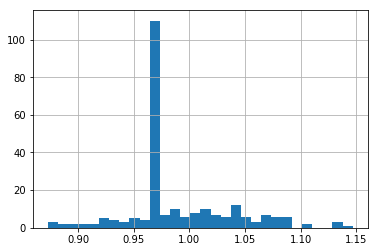

In [28]:
cv_by_avg_value['score'].hist(bins=30)

### Run best ML strategy

In [29]:
ml_predictions = get_ml_predict(
    sklearn.linear_model.SGDClassifier(alpha=0.1, loss='hinge', l1_ratio=0.6, penalty='elasticnet', tol=1e-4, random_state=42),
    X_svd, y_all, train_test_split / len(X_svd), print_progress=True
)

Done 100.00% percents

In [30]:
start_pool = 100000
run_dates = dates[train_test_split:]
best_ml_results = {
    'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates)[0],
    'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)[0]
}

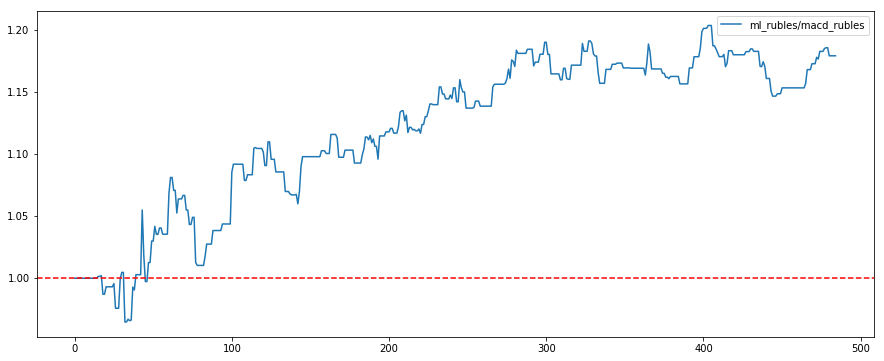

In [31]:
plt.figure(figsize=(15, 6))

plt.plot(best_ml_results['ml']/best_ml_results['macd'])
plt.axhline(1, color='red', linestyle='--')
plt.legend(['ml_rubles/macd_rubles'])

plt.show()

In [32]:
print('Average ratio: ', (best_ml_results['ml']/best_ml_results['macd']).mean())

Average ratio:  1.1196936761733765


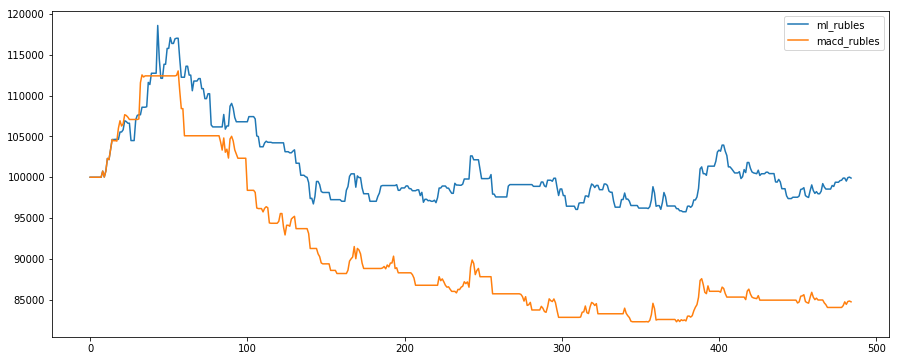

In [33]:
plt.figure(figsize=(15, 6))

plt.plot(best_ml_results['ml'])
plt.plot(best_ml_results['macd'])
plt.legend(['ml_rubles', 'macd_rubles'])

plt.show()

## Tf-Idf

In [34]:
tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
X_tfidf_svd = sklearn.preprocessing.scale(
    tfidf_transformer.fit_transform(np.load('lemmas/2010p/bow_avg_2010.npy')).toarray(),
    copy=False)
svd = sklearn.decomposition.TruncatedSVD(1750)
X_tfidf_svd = svd.fit_transform(X_tfidf_svd)
gc.collect()

5454

In [35]:
X_tfidf_svd = sharedmem.copy(X_tfidf_svd)
y_all = sharedmem.copy(y_all)
gc.collect()

0

In [36]:
train_test_split = int(0.75 * len(X_tfidf_svd))
train_valid_split = 1/2 / 0.75
cv_results = run_grid_search(sklearn.linear_model.SGDClassifier, get_all_params(sgd_params),
                             X_tfidf_svd[:train_test_split], y_all[:train_test_split],
                             train_valid_split, print_progress=True)

Done 8.68% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 19.83% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 31.82% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 47.11% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 59.50% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 94.21% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 100.00% percents

In [37]:
cv_by_avg_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'].mean()} for r in cv_results]).sort_values('score', ascending=False)
cv_by_avg_value

,alpha,l1_ratio,loss,score
237,0.10000,0.9,log,1.180276
99,0.10000,0.5,log,1.146748
31,0.10000,0.6,hinge,1.144680
164,0.00100,0.6,hinge,1.136300
119,0.00010,0.6,log,1.133311
62,0.10000,0.7,log,1.120277
13,0.01000,0.6,log,1.116457
241,0.10000,1.0,log,1.115438
10,1.00000,0.1,hinge,1.110003
145,0.10000,0.4,log,1.103819


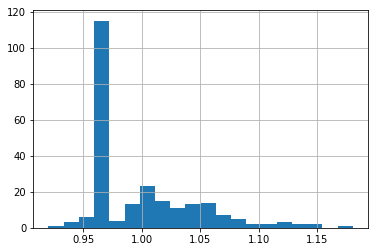

In [39]:
cv_by_avg_value['score'].hist(bins=20)

In [40]:
# by last value
cv_by_last_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'][-1]} for r in cv_results]).sort_values('score', ascending=False)
cv_by_last_value

,alpha,l1_ratio,loss,score
237,0.10000,0.9,log,1.443269
31,0.10000,0.6,hinge,1.423543
99,0.10000,0.5,log,1.363037
241,0.10000,1.0,log,1.321012
238,0.01000,1.0,hinge,1.306119
119,0.00010,0.6,log,1.281300
13,0.01000,0.6,log,1.276012
164,0.00100,0.6,hinge,1.273684
62,0.10000,0.7,log,1.262325
10,1.00000,0.1,hinge,1.258018


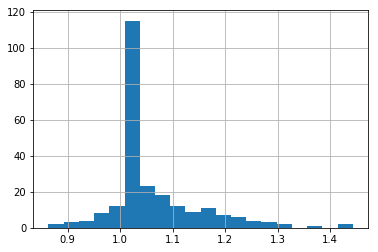

In [42]:
cv_by_last_value['score'].hist(bins=20)

In [43]:
ml_predictions = get_ml_predict(
    sklearn.linear_model.SGDClassifier(alpha=0.1, loss='log', l1_ratio=0.9, penalty='elasticnet', tol=1e-4, random_state=42),
    X_tfidf_svd, y_all, train_test_split / len(X_tfidf_svd), print_progress=True)

Done 100.00% percents

In [44]:
start_pool = 100000
run_dates = dates[train_test_split:]
best_ml_results = {
    'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates)[0],
    'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)[0]
}

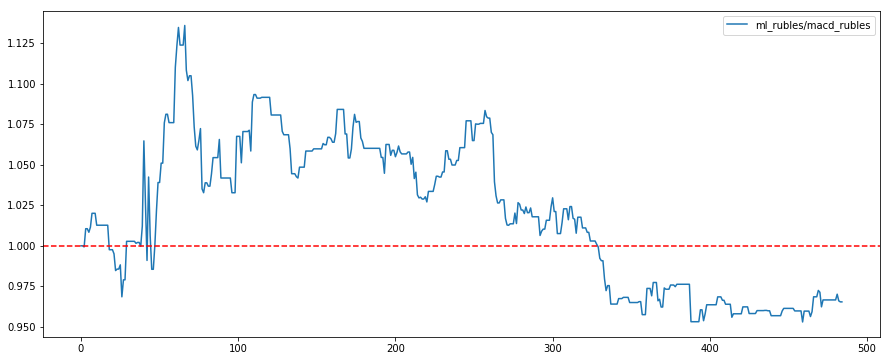

In [45]:
plt.figure(figsize=(15, 6))

plt.plot(best_ml_results['ml']/best_ml_results['macd'])
plt.axhline(1, color='red', linestyle='--')
plt.legend(['ml_rubles/macd_rubles'])

plt.show()

In [46]:
print('Average ratio: ', (best_ml_results['ml']/best_ml_results['macd']).mean())

Average ratio:  1.0197629360614955
